# Adult Vector Abundance

## Location: Garki, Kenya

In [63]:
import pandas as pd
import numpy as np
import matplotlib 
%matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import math

In [64]:
raindf = pd.DataFrame.from_csv("msim/garki_rainfall.csv", header=None, infer_datetime_format=True)
raindf.columns=['p']
tempdf = pd.DataFrame.from_csv("msim/garki_temperature.csv", header=None, infer_datetime_format=True)
tempdf.columns=['degc']
humidf = pd.DataFrame.from_csv("msim/garki_humidity.csv", header=None, infer_datetime_format=True)
humidf.columns=['relhum']

## Access of the Weather Files

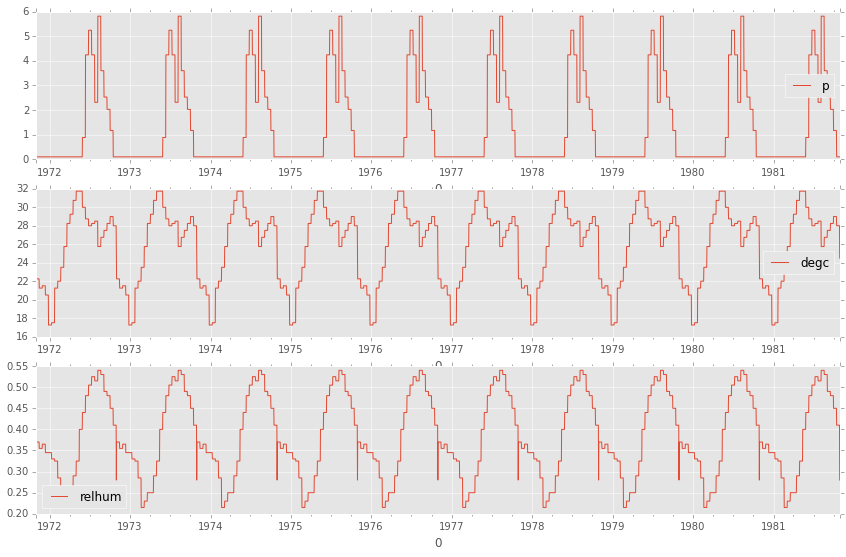

In [65]:
fig, ax = plt.subplots(3, 1, figsize=(1.6*9,1*9))
raindf.plot(ax=ax[0])
tempdf.plot(ax=ax[1])
humidf.plot(ax=ax[2])


### Convert Temperature from Celcius to Kelvin

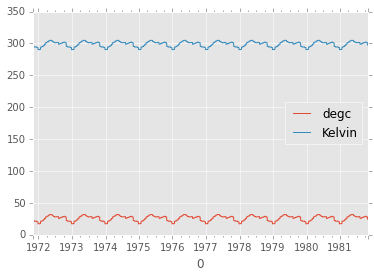

In [139]:
tempdf['Kelvin'] = tempdf['degc'] + 273.15 # convert to units of Kelvin 
tempdf.plot()

### Current Larval Capacity Given a Vector Habitat Type

In [184]:
# Htemp = Temporary habitat  
# Ktemp (Habitat scalar)
# Dcell = in a grid of diameter Dcell (1 arc sec at the equator is about 30.87m,  
# Prain = increases with rainfall Prain and 
# tautemp = decays with a rate τtemp proportional to the evaporation rate driven by 
# Tk = temperature T (K) 
# Hm= humidity (I think it's relative humidity, expressed as a percentage)(absolute? units gram per cubic metre)
# R Gas constant in units J K^{-1} mol^{-1}
# Htemp + Htemp(deltat/tautemp) = Prain * Ktemp * Dcell**2
# Htemp(1+ deltat/tautemp) = Prain * Ktemp * Dcell**2
# H_temp += P_rain * K_temp * D_cell**2  / (1+ delta_t/tau_temp)

# m_current_larval_capacity += (float)( localWeather->accumulated_rainfall() 
#  * m_max_larval_capacity * params()->lloffset * params()->lloffset - m_current_larval_capacity 
#  * exp(LARVAL_HABITAT_FACTOR1 / (localWeather->airtemperature() + CELSIUS_TO_KELVIN)) 
#  * LARVAL_HABITAT_FACTOR2 * params()->tempHabitatDecayScalar * sqrt(LARVAL_HABITAT_FACTOR3 
#  / (localWeather->airtemperature() + CELSIUS_TO_KELVIN)) * (1.0f - localWeather->humidity()) * dt );

# A = -5628.1 Kelvin; B = Tk
# k_tempdecay = 0.05
# 
# LHF2 = (5.1x1011Pa)
# Htemp * exp(A/B) * LHF2 k
# curLrvCap   = m_current_larval_capacity 
# raindf['p'] = localWeather->accumulated_rainfall()
# Ktemp       = m_max_larval_capacity
# Dcell       = params()->lloffset



Ktemp = 1.25e+9 #   1.25 × 10^9 for gambiae 
ktempdecay = 0.05 # k_tempdecay

R = 8.31451
tautmp = pd.Series()
loss2evap = pd.Series()

for i in range(0,np.shape(tempdf)[0]):
    A = 5.1e+11 * math.exp(-5628.1/tempdf['Kelvin'].iloc[i])
    B = ktempdecay * math.sqrt(.018/(2.0*math.pi*R*tempdf['Kelvin'].iloc[i]))
    C = (1-humidf['relhum'].iloc[i])
    tautmp.at[i] = (1.0/(A*B*C))

#print (ttmpser.head())    
Dcell = 30.86666667 * 1 # 1 arc sec at the equator ... optimize for the location of garki

Htemp = 0 # initial cond; no rain
H= pd.DataFrame()
#print raindf['p'].iloc[delta_t] * Ktemp * Dcell*Dcell
hconst=pd.Series()
h_tmp = pd.Series()
for dt in range(0,np.shape(raindf)[0]):
    Htemp += raindf['p'].iloc[dt] * Ktemp * Dcell*Dcell  - Htemp * (1/tautmp.ix[dt])
    hconst.at[dt] = Ktemp * Dcell*Dcell
    h_tmp.at[dt]  = Htemp
    loss2evap.at[dt]= Htemp * (1/tautmp.ix[dt])

h_tmp.replace([np.inf, -np.inf], np.nan)
H['temp']  = h_tmp
H['const'] = hconst
H['loss']  = loss2evap


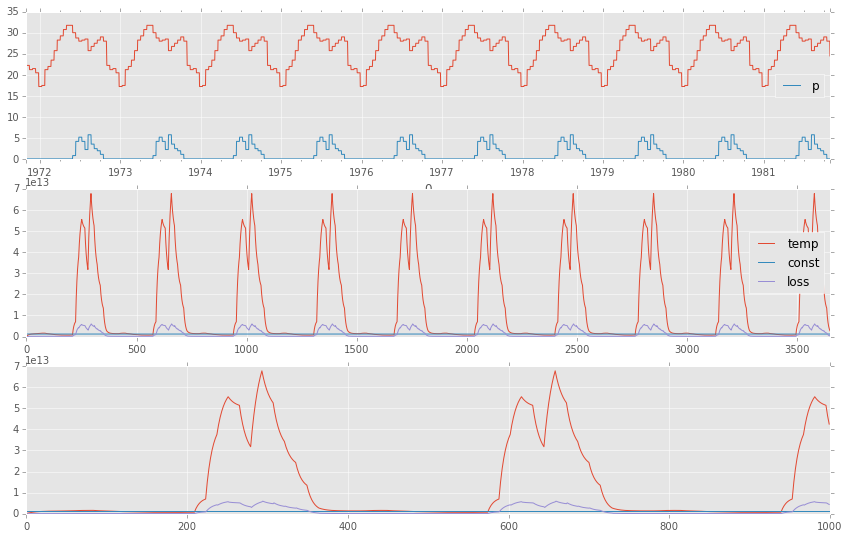

In [193]:
fig, ax = plt.subplots(3, 1, figsize=(1.6*9,1*9))
# # HDecay.dropna()
# # HDecay.plot(ax=ax[0])
# tautmp.plot(ax=ax[0])
# tempdf.plot(ax=ax[1])
# curLrvCap.plot(ax=ax[1])
H.dropna()
tempdf['degc'].plot(ax=ax[0])
raindf.plot(ax=ax[0])

H.plot(ax=ax[1])
ax1 = ax[2]
ax1.plot(H[:][:1000])